## LOAD DATA


In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np
import seaborn as sns

idx = pd.IndexSlice

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [2]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    # change fps to str varaiable
    df['fps'] = df['fps'].astype(str)
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [3]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

df = pd.concat(dfs).sort_index()

## FILTER DATA


### Filter duplicated scenarios

Filter scenarios that are exactly the same


In [4]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df = df.drop(excluded_routes, level='route_index', axis=0)

### Filter 16 FPS

Carla crashes at 16 so we need to filter this results out


In [5]:
# filter out 16 fps
df = df.drop("16", level='fps', axis=0)

In [6]:
df

route_id                    status  \
rep fps highquality route_index                                                
0   10  False       0              RouteScenario_0  Failed - Agent timed out   
                    1              RouteScenario_1  Failed - Agent timed out   
                    2              RouteScenario_2  Failed - Agent timed out   
                    3              RouteScenario_3  Failed - Agent timed out   
                    4              RouteScenario_4  Failed - Agent timed out   
...                                            ...                       ...   
9   20  True        127          RouteScenario_127                 Completed   
                    128          RouteScenario_128                 Completed   
                    129          RouteScenario_129                 Completed   
                    130          RouteScenario_130                 Completed   
                    131          RouteScenario_131  Failed - Agent timed out   

                                                     infractions.collisions_layout  \
rep fps highquality route_index                                                      
0   10  False       0                                                           []   
                    1                                                           []   
                    2            [Agent collided against object with type=stati...   
                    3                                                           []   
                    4                                                           []   
...                                                                            ...   
9   20  True        127                                                         []   
                    128                                                         []   
                    129                                                         []   
                    130                                                         []   
                    131                                                         []   

                                infractions.collisions_pedestrian  \
rep fps highquality route_index                                     
0   10  False       0                                          []   
                    1                                          []   
                    2                                          []   
                    3                                          []   
                    4                                          []   
...                                                           ...   
9   20  True        127                                        []   
                    128                                        []   
                    129                                        []   
                    130                                        []   
                    131                                        []   

                                                    infractions.collisions_vehicle  \
rep fps highquality route_index                                                      
0   10  False       0            [Agent collided against object with type=vehic...   
                    1            [Agent collided against object with type=vehic...   
                    2                                                           []   
                    3                                                           []   
                    4                                                           []   
...                                                                            ...   
9   20  True        127                                                         []   
                    128                                                         []   
                    129                                                         []   
                    130          [Agen

## PROCESS DATA


### Driving score error


In [7]:
oracle_df = df.xs(("20", "True"), level=[
    'fps', 'highquality'], drop_level=False).sort_index()
oracle_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1280 entries, (0, '20', 'True', 0) to (9, '20', 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           1280 non-null   object 
 1   status                             1280 non-null   object 
 2   infractions.collisions_layout      1280 non-null   object 
 3   infractions.collisions_pedestrian  1280 non-null   object 
 4   infractions.collisions_vehicle     1280 non-null   object 
 5   infractions.outside_route_lanes    1280 non-null   object 
 6   infractions.red_light              1280 non-null   object 
 7   infractions.route_dev              1280 non-null   object 
 8   infractions.route_timeout          1280 non-null   object 
 9   infractions.stop_infraction        1280 non-null   object 
 10  infractions.vehicle_blocked        1280 non-null   object 
 11  duration_game      

In [8]:

# oracle driving score per scenario
oracle_vec = oracle_df.groupby('route_index')['driving_score'].mean()
df['driving_score_error'] = (df['driving_score'] - oracle_vec).abs()

# df

## INVESTIGATE


### Labeling

Labeling scenario safety


In [9]:
# consider only highquality rendering for now
data = df.xs("True", level='highquality')

# average the data across repetitions
data = data.groupby(['fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()

In [10]:

safe_threshold = 0.01
risky_threshold = 0.25

data.loc[:, 'label'] = np.select(
    [data['driving_score_error'] < safe_threshold,
     data['driving_score_error'].between(safe_threshold, risky_threshold),
     data['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

In [11]:
def draw_dist(data):

    fig, (ax1,  ax2) = plt.subplots(1, 2, sharex=True)

    # fig.set_figheight(15)
    fig.set_figwidth(10)

    sns.histplot(
        data, x="fps", hue='label', hue_order=['risky', 'moderate', 'safe'], multiple="stack",  shrink=.8, ax=ax1
    )

    sns.stripplot(data, x='fps', y='driving_score_error', hue_order=['risky', 'moderate', 'safe'],
                  hue='label', ax=ax2)

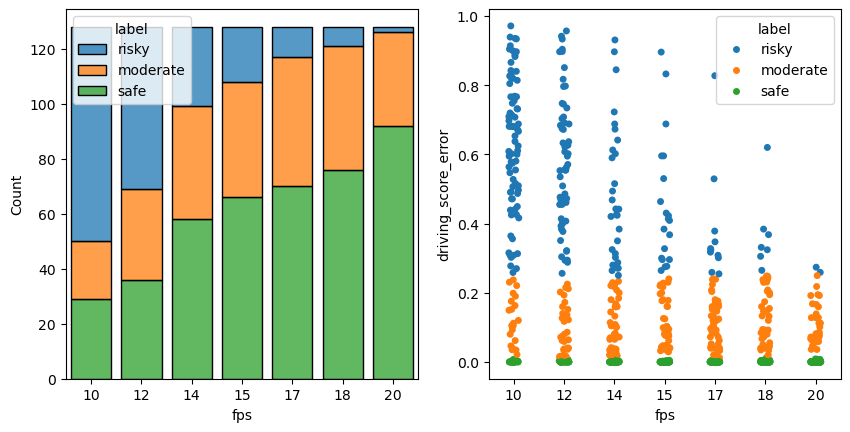

In [12]:
draw_dist(data)

### Non flakey

Keep only safe scenarios from highfidelity


In [13]:
highfid = data.xs("20")
safe_mask = highfid['label'] == 'safe'
# safe_mask
nonflakey = data.where(safe_mask).dropna()

In [14]:
nonflakey.groupby('fps').count()

,driving_score_error,label
fps,,
10,92,92
12,92,92
14,92,92
15,92,92
17,92,92
18,92,92
20,92,92


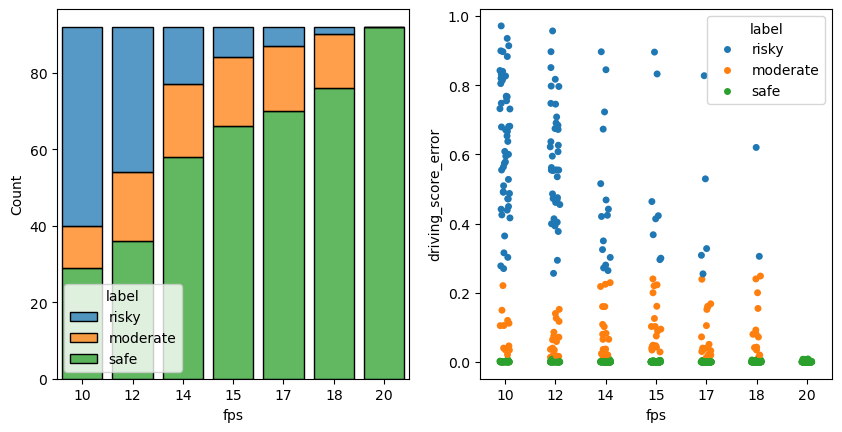

In [15]:

draw_dist(nonflakey)

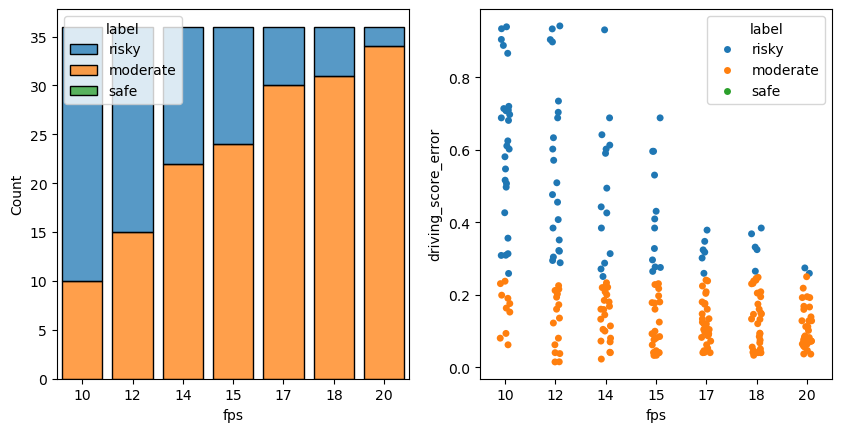

In [16]:
onlyflakey = data.where(~safe_mask).dropna()
draw_dist(onlyflakey)

### Sankey diagram


In [17]:
from itertools import product
from dataclasses import dataclass


@dataclass
class Transition:
    """Class for keeping track of an item in inventory."""
    source_fps: str
    source_label: str
    target_fps: str
    target_label: str
    value: int

    @property
    def source(self) -> str:
        return f"{self.source_fps} {self.source_label}"

    @property
    def target(self) -> str:
        return f"{self.target_fps} {self.target_label}"

    def __str__(self) -> str:
        return f'For {self.source_fps} {self.source_label} -> {self.target_fps} {self.target_label}: {self.value}'


transitions: list[Transition] = []

In [18]:
fps_values = ["10", "15", "20"]
sankey_data = data.loc[fps_values, :]

In [19]:

# reversing at the end
batches = list(sankey_data.groupby('fps'))[::-1]

# outer loop iterates over pairs of fps values (20, 18), (18, 17), (17, 15)...
for (source_fps, source_batch), (target_fps, target_batch) in zip(batches, batches[1:]):

    source_batches = list(source_batch.groupby('label'))
    target_batches = list(target_batch.groupby('label'))

    # inner loop iterates over pairs (safe, safe), (safe, moderate) ... to capture transitions
    for (source_label, source_label_batch),  (target_label, target_label_batch) in product(source_batches, target_batches):

        # merge batches with inner to calculate intersection between them
        merged = pd.merge(source_label_batch, target_label_batch,
                          how='inner', on=['route_index'])

        # size of merged is transition value
        value = merged.shape[0]
        t = Transition(source_fps, source_label,
                       target_fps, target_label, value)
        # print(t)
        transitions.append(t)

In [20]:
from itertools import cycle

figure_labels = [(t.source, t.target) for t in transitions]
figure_labels = {x for xs in figure_labels for x in xs}
figure_labels = list(figure_labels)
figure_labels = sorted(figure_labels, reverse=True)
fl_index_mapping = {fg: i for i, fg in enumerate(figure_labels)}
fl_index_mapping

colors = cycle(['rgb(0, 200, 0)', 'rgb(200, 0, 0)',  'rgb(0, 0, 200)'])
fl_color_mapping = dict(zip(figure_labels, colors))
fl_color_mapping.values()

dict_values(['rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)'])

In [21]:
links = np.array([(fl_index_mapping[t.source], fl_index_mapping[t.target], t.value)
                  for t in transitions])
links = links.T
# links

In [22]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="green", width=0.5),
        label=list(fl_index_mapping.keys()),
        customdata=list(fl_index_mapping.keys()),
        hovertemplate='%{customdata} has total value %{value}<extra></extra>',
        color=list(fl_color_mapping.values())
    ),
    link=dict(

        arrowlen=0,
        source=links[0],
        target=links[1],
        value=links[2],
        hovertemplate=' ',
    ))])

fig.update_layout(font_size=20)

### Marking at 10FPS


<Axes: xlabel='fps', ylabel='driving_score_error'>

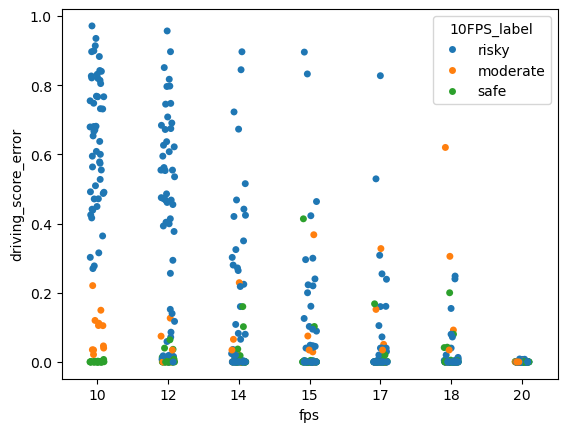

In [23]:
fps10_labels = data.xs("10")['label'].rename("10FPS_label")


sns.stripplot(nonflakey.join(fps10_labels), x='fps', y='driving_score_error', hue_order=['risky', 'moderate', 'safe'],
              hue='10FPS_label',)

### Identifying Safe scenarios


#### Indexes of safe scenarios


In [24]:
from functools import reduce

safe_routes = []
for fps, batch in data.groupby('fps', as_index=False):

    mask = batch['label'] == 'safe'
    safe_routes_for_fps = batch[mask].reset_index()['route_index'].to_list()
    safe_routes.append(safe_routes_for_fps)


def common_elements(x: list, y: list):
    return list(set(x).intersection(y))


safe_routes = reduce(common_elements, safe_routes)
safe_routes

[24,
 25,
 30,
 31,
 35,
 42,
 43,
 47,
 66,
 67,
 69,
 71,
 85,
 86,
 91,
 93,
 102,
 103,
 104,
 107,
 112]

In [25]:
safe_data = df.xs("10", level='fps')
safe_data = safe_data[safe_data.index.get_level_values(
    'route_index').isin(safe_routes)]

to_watch = safe_data.xs(0, level='rep').xs("True", level='highquality')
to_watch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 24 to 112
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           21 non-null     object 
 1   status                             21 non-null     object 
 2   infractions.collisions_layout      21 non-null     object 
 3   infractions.collisions_pedestrian  21 non-null     object 
 4   infractions.collisions_vehicle     21 non-null     object 
 5   infractions.outside_route_lanes    21 non-null     object 
 6   infractions.red_light              21 non-null     object 
 7   infractions.route_dev              21 non-null     object 
 8   infractions.route_timeout          21 non-null     object 
 9   infractions.stop_infraction        21 non-null     object 
 10  infractions.vehicle_blocked        21 non-null     object 
 11  duration_game                      21 non-null     float64
 12 

In [26]:
to_watch[['status', 'driving_score',  'driving_score_error']]

,status,driving_score,driving_score_error
route_index,,,
24,Completed,1.000000,0.000000
25,Completed,1.000000,0.000703
30,Completed,1.000000,0.000000
31,Failed - Agent got blocked,0.647951,0.000000
35,Completed,1.000000,0.000000
42,Completed,1.000000,0.000000
43,Failed - Agent got blocked,0.520909,0.000000
47,Completed,1.000000,0.000000
66,Completed,1.000000,0.000000


In [27]:
to_watch

,route_id,status,infractions.collisions_layout,infractions.collisions_pedestrian,infractions.collisions_vehicle,infractions.outside_route_lanes,infractions.red_light,infractions.route_dev,infractions.route_timeout,infractions.stop_infraction,infractions.vehicle_blocked,duration_game,duration_system,route_length,score_composed,score_penalty,score_route,driving_score,driving_score_error
route_index,,,,,,,,,,,,,,,,,,,
24,RouteScenario_24,Completed,[],[],[],[],[],[],[],[],[],62.100001,151.234752,345.257465,100.000000,1.0,100.000000,1.000000,0.000000
25,RouteScenario_25,Completed,[],[],[],[],[],[],[],[],[],92.900001,232.032916,434.280454,100.000000,1.0,100.000000,1.000000,0.000703
30,RouteScenario_30,Completed,[],[],[],[],[],[],[],[],[],127.600002,309.190512,650.671267,100.000000,1.0,100.000000,1.000000,0.000000
31,RouteScenario_31,Failed - Agent got blocked,[],[],[],[],[],[],[],[],"[Agent got blocked at (x=16.012, y=111.547, z=...",299.300004,820.951343,820.128992,64.795140,1.0,64.795140,0.647951,0.000000
35,RouteScenario_35,Completed,[],[],[],[],[],[],[],[],[],50.500001,133.660819,95.103699,100.000000,1.0,100.000000,1.000000,0.000000
42,RouteScenario_42,Completed,[],[],[],[],[],[],[],[],[],86.600001,207.776853,373.908287,100.000000,1.0,100.000000,1.000000,0.000000
43,RouteScenario_43,Failed - Agent got blocked,[],[],[],[],[],[],[],[],"[Agent got blocked at (x=15.937, y=100.106, z=...",261.800004,710.098841,590.323961,52.090869,1.0,52.090869,0.520909,0.000000
47,RouteScenario_47,Completed,[],[],[],[],[],[],[],[],[],110.800002,250.157395,525.504214,100.000000,1.0,100.000000,1.000000,0.000000
66,RouteScenario_66,Completed,[],[],[],[],[],[],[],[],[],60.600001,142.878523,277.033432,100.000000,1.0,100.000000,1.000000,0.000000


## SAVE DATA


In [28]:
# data.to_pickle("evaluation_data.pkl")